In [1]:
import pandas as pd
import numpy as np

import torch
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [2]:
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
import random

In [9]:
from transformers.optimization import Adafactor
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup
import datasets

In [4]:
data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

data.data_split.value_counts()

train    104317
test      35648
dev       34998
val        1743
Name: data_split, dtype: int64

In [5]:
data_train = data[data.data_split=='train']
data_val = data[data.data_split=='val'].copy()
data_train.sample(3)

,date,ba,ru,is_correct,data_split
92455,19/10/2022 13:56:22,Ни эшләп ҡарарға һуң?,Что же предпринять?..,1,train
172483,29/01/2023 16:02:04,"– Әйҙә, ул, моғайын, берәй аҡыл өйрәтер...","– Пойдем, он обязательно поможет...",0,train
82339,18/09/2022 19:02:54,Баҙнат итмәне.,Не посмел он.,1,train


In [10]:
larger_parallel = datasets.load_dataset('AigizK/bashkir-russian-parallel-corpora')

Using custom data configuration AigizK--bashkir-russian-parallel-corpora-fbaef55783976247


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/710718 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/david/.cache/huggingface/datasets/AigizK___parquet/AigizK--bashkir-russian-parallel-corpora-fbaef55783976247/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
base_model = 'bert-base-multilingual-cased'

# Loading the replacers

In [11]:
data_train_correct = data_train[data_train.is_correct == 1]
print(data_train_correct.shape, data_train.shape)

(81268, 5) (104317, 5)


In [66]:
all_pairs = [(row.ba, row.ru) for row in tqdm(data_train_correct.itertuples()) if row.ba.strip() and row.ru.strip()]
len(all_pairs)

0it [00:00, ?it/s]

81268

In [67]:
for item in tqdm(larger_parallel['train']):
    if item['ba'].strip() and item['ru'].strip():
        all_pairs.append((item['ba'], item['ru']))
len(all_pairs)

  0%|          | 0/710718 [00:00<?, ?it/s]

791985

In [15]:
# borrowed from https://github.com/natasha/naeval/tree/master/naeval/segment

import re
from collections import namedtuple


TOKEN = re.compile(r'([^\W\d]+|\d+|[^\w\s])')
WORD = re.compile('^[\w\d]+$')

Substring = namedtuple('Substring', ['start', 'end', 'text'])

def find_substrings(chunks, text):
    offset = 0
    for chunk in chunks:
        start = text.find(chunk, offset)
        stop = start + len(chunk)
        yield Substring(start, stop, chunk)
        offset = stop

def re_tokenize(text):
    chunks = TOKEN.findall(text)
    return find_substrings(chunks, text)

def is_word(text):
    return bool(re.match(WORD, text))

In [16]:
def insert_word(sent, word, position=None):
    """ Cleanly insert a word randomly into a sentence"""
    toks = list(re_tokenize(sent))
    # before which token we'll insert the word
    if position is None:
        position = random.randint(0, len(toks) if is_word(toks[-1].text) else len(toks)-1)
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        return word + ' ' + sent[0].lower() + sent[1:]
    if position == len(toks): # the last token is a word, so we just add one more
        return sent + ' ' + word
    next_tok = toks[position]
    if is_word(next_tok.text) or sent[next_tok.start-1] == ' ':
        word = word + ' '  # insert space between the added word and the next one
    else:
        word = ' ' + word
    return sent[:next_tok.start] + word + sent[next_tok.start:]

def remove_word(sent, position=None):
    """ Cleanly remove a word randomly from a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    
    if position == 0:
        res = sent[toks[1].start:]
        if sent[0].isupper():
            res = res[0].upper() + res[1:]
        return res
    if position == len(toks)-1:
        return sent[:toks[-2].end]
    tok = toks[position]
    spaces_around = (sent[tok.start-1] == ' ') + (sent[tok.end] == ' ')
    extra_space = ''
    if spaces_around == 2 or not is_word(tok.text) and spaces_around == 1:
        extra_space = ' '
    return sent[:toks[position-1].end] + extra_space + sent[toks[position+1].start:]


def replace_word(sent, word, position=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 1:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    tok = toks[position]
    
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        res = word
    else:
        res = sent[:tok.start] + (' ' if sent[tok.start-1] != ' ' and not is_word(tok.text) else '') + word
    if position < len(toks) - 1:
        if sent[tok.end] != ' ' and not is_word(tok.text):
            res = res + ' '
        res = res + sent[tok.end:]
    return res


def swap_words(sent, position1=None, position2=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position1 is None:
        position1 = random.randint(0, len(toks)-1)
    while position2 is None or position2 == position1:
        position2 = random.randint(0, len(toks)-1)
    w1, w2 = toks[position1].text, toks[position2].text
    
    sent = replace_word(sent, w2, position1)
    sent = replace_word(sent, w1, position2)
    return sent


def get_other_word(ix):
    sent = random.choice(all_pairs)[ix]
    return random.choice(list(re_tokenize(sent))).text


def corrupt_sentence(sent, ix, p_edit=0.5):
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent.split()) == 1:
            sent = insert_word(sent, get_other_word(ix))
        # replace a random word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = replace_word(sent, get_other_word(ix))
        # remove a word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = remove_word(sent)
        # swap words
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = swap_words(sent)
    return sent

def corrupt_pair(pair):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])
    sent = pair[ix]
    pair[ix] = corrupt_sentence(sent, ix)
    return pair

In [69]:
for ba, ru in tqdm(all_pairs):
    b1 = random.choice(list(re_tokenize(ba))).text
    b2 = random.choice(list(re_tokenize(ru))).text

  0%|          | 0/791985 [00:00<?, ?it/s]

In [17]:
pair = random.choice(all_pairs)
pair

('Саралар киске сәғәт 9-ға тиклем дауам итә.',
 'Мероприятия продлятся до 21 часов вечера.')

In [18]:
def get_pairs_contrastive_batch(bs=4, p_difficult=0.5):
    assert bs >= 4
    batch = random.sample(all_pairs, bs // 2) # data_train_correct.sample(bs // 2)
    pp = batch # [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [1 for row in pp]
    if random.random() < p_difficult:
        for i in range(len(pp)):
            pp.append(corrupt_pair(pp[i]))
            labels.append(0)
    else:
        for i in range(len(pp)):
            pp.append([pp[i][0], pp[i-1][1]])
            labels.append(0)
    return [list(t) for t in zip(*pp)], labels

In [30]:
%%time

get_pairs_contrastive_batch(8)

Wall time: 999 µs


([['Ниһайәт, дөйөм көс менән дошмандың кәрәген биреп талап, ҡыуып ебәрҙеләр...',
   'Уны, рәйесте лә, бер кем дә күрмәйме икән ни? Выползоктың асыуы ҡабара башланы.',
   'Йәмғиәт ҡуртымда булған приискыларҙы 1,2 млн һумға һатып ала, уларҙы тергеҙеүгә яҡынса 4 млн һум аҡса бүлә.',
   'Ф.Ә.Мөхәмәҙиев, Ә.З.Әсфәндиәров',
   'Ниһайәт, дөйөм көс менән дошмандың кәрәген биреп талап, алып Нефтеюганскиҙа ебәрҙеләр . .',
   'Уны, рәйесте лә, бер кем дә күрмәйме икән ни? Выползоктың асыуы ҡабара башланы.',
   'Йәмғиәт ҡуртымда булған приискыларҙы 1,2 млн һумға һатып ала, уларҙы тергеҙеүгә яҡынса 4 млн һум аҡса бүлә.',
   'Ф.Ә.Мөхәмәҙиев, Ә.З.Әсфәндиәров'],
  ['Наконец, всеобщими усилиями врага крепко отлупили и прогнали...',
   'Неужто и его, председателя, никто не видит? – начинал злиться Выползок.',
   'Об-во выкупило арендуемые прииски за 1,2 млн. руб., на их реконструкцию выделило около 4 млн. рублей.',
   'А.З.Асфандияров, Ф.А.Мухамадеев',
   'Наконец, всеобщими усилиями врага крепко отлупил

# Training

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(base_model).cuda();
tokenizer = AutoTokenizer.from_pretrained(base_model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [32]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [33]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-4, clip_threshold=1.0
)
cleanup()

In [34]:
losses = []

In [35]:
head_steps = 5_000
batch_size = 8
report_steps = 100
train_max_length = 256

In [36]:
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=head_steps)

In [47]:
model.train()
tq = trange(len(losses), head_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/1675 [00:00<?, ?it/s]

3400 0.5629997463524341
3500 0.5300789499282836
3600 0.591562531888485
3700 0.5655757082998752
3800 0.5774815982580185
3900 0.5890865369141102
4000 0.5540728889405727
4100 0.567785209864378
4200 0.5381500406563282
4300 0.569883159995079
4400 0.5627700370550156
4500 0.5522523668408393
4600 0.5869616617262363
4700 0.5838814347982406
4800 0.5762402576208114
4900 0.5545455200970173


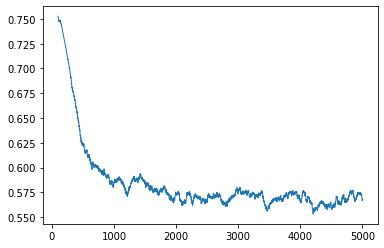

In [48]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [49]:
for p in model.parameters():
    p.requires_grad = True

In [50]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [51]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [52]:
full_steps = 95_000
batch_size = 4
report_steps = 100
train_max_length = 192  # 256 is preferable, but it OOMs often

In [53]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=full_steps)

In [70]:
model.train()
tq = trange(len(losses), head_steps + full_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/86286 [00:00<?, ?it/s]

13800 0.2999666390195489
13900 0.3067506008222699
14000 0.2554459646344185
14100 0.3581089997291565
14200 0.21982111483812333
14300 0.2741813230887055
14400 0.23492953341454267
14500 0.2694403387978673
14600 0.28539589684456584
14700 0.22736445885151624
14800 0.2980279953405261
14900 0.20467423915863037
15000 0.31671575967222454
15100 0.22575838316231966
15200 0.3516950497031212
15300 0.29477477610111236
15400 0.28550301015377044
15500 0.2567489616200328
15600 0.3218000984936953
15700 0.3177188452705741
15800 0.22818398725241423
15900 0.28176056925207377
16000 0.27600312765687707
16100 0.2886092363297939
16200 0.2999062428623438
16300 0.3708608642593026
16400 0.21884393818676473
16500 0.29623034615069627
16600 0.29894253056496384
16700 0.2799785567447543
16800 0.24811633817851544
16900 0.29133743789047
17000 0.23235562082380057
17100 0.25106187365949156
17200 0.28143834192305806
17300 0.3026966218650341
17400 0.2837377021461725
17500 0.24420112267136573
17600 0.3095839034020901
17700 0

46000 0.2190381432324648
46100 0.24154440883547068
46200 0.23153457447886466
46300 0.2683115907385945
46400 0.2544430474191904
46500 0.22256298400461674
46600 0.27272337563335897
46700 0.291234345510602
46800 0.29740139096975327
46900 0.23419685054570435
47000 0.21154804226011037
47100 0.20537720173597335
47200 0.23545758668333291
47300 0.21972711283713578
47400 0.2338596887513995
47500 0.1726710234209895
47600 0.26237269848585126
47700 0.24540470194071531
47800 0.241753822080791
47900 0.24200358506292105
48000 0.20191434536129235
48100 0.22778935078531504
48200 0.2783385302498937
48300 0.2977017670869827
48400 0.18297227684408426
48500 0.28732610791921614
48600 0.23943846613168718
48700 0.26221197497099635
48800 0.2470037828758359
48900 0.2084696837887168
49000 0.19675655458122493
49100 0.23519099436700344
49200 0.26535078302025794
49300 0.26762461196631193
49400 0.20816281460225583
49500 0.2911350617930293
49600 0.20434834018349649
49700 0.2154044508561492
49800 0.21028835486620664
4

78000 0.23431846454739572
78100 0.21541867777705193
78200 0.23238142736256123
78300 0.19073674481362105
78400 0.24553322572261094
78500 0.23159605279564857
78600 0.22035422906279564
78700 0.1870489225536585
78800 0.24097600065171718
78900 0.18734418254345656
79000 0.20081325229257346
79100 0.22437463279813527
79200 0.2218767400830984
79300 0.20293123807758093
79400 0.21102264851331712
79500 0.20675738774240016
79600 0.23018899876624346
79700 0.21671619832515718
79800 0.19513485874980688
79900 0.22999503817409278
80000 0.21764558754861354
80100 0.26159255038946866
80200 0.21552474346011877
80300 0.3105114224553108
80400 0.18767954099923373
80500 0.1821714160218835
80600 0.23669410195201634
80700 0.16672488201409577
80800 0.20414321202784777
80900 0.21525816015899182
81000 0.1601765574887395
81100 0.20824879076331854
81200 0.18280260443687438
81300 0.21004450291395188
81400 0.2292099665477872
81500 0.23206901926547288
81600 0.20967654939740896
81700 0.24850453235208989
81800 0.2433782751

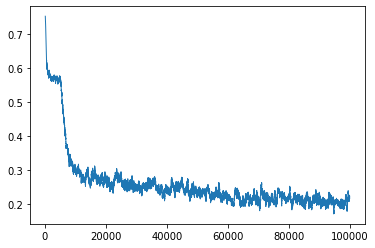

In [71]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [72]:
loss = None
cleanup()
model.eval();

In [73]:
eval_bs = 8

In [74]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

  0%|          | 0/218 [00:00<?, ?it/s]

0.7548173301929219
recall@ ideal reject rate: 0.5064599483204134 th: 0.9034699008715131


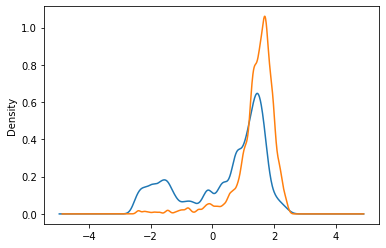

In [75]:
pd.Series(np.log10(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [76]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.86219895
0.8955823293172691


In [77]:
model.save_pretrained('../models/bak-ru-cross-v3-hard-negatives-more-data');

# Now try fine-tuning it on good contrastive pairs and supervised pairs

In [78]:
all_pairs_clean = [(row.ba, row.ru) for row in tqdm(data_train_correct.itertuples()) if row.ba.strip() and row.ru.strip()]
print(len(all_pairs_clean))

0it [00:00, ?it/s]

81268


In [80]:
all_pairs_negative = [
    (row.ba, row.ru) for row in tqdm(data_train[data_train.is_correct == 0].itertuples()) 
    if row.ba.strip() and row.ru.strip()
]
print(len(all_pairs_negative))

0it [00:00, ?it/s]

23049


In [81]:
def get_pairs_contrastive_batch_clean(bs=4, p_difficult=0.5):
    assert bs >= 4
    batch = random.sample(all_pairs_clean, bs // 2) # data_train_correct.sample(bs // 2)
    pp = batch # [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [1 for row in pp]
    if random.random() < p_difficult:
        for i in range(len(pp)):
            pp.append(corrupt_pair(pp[i]))
            labels.append(0)
    else:
        for i in range(len(pp)):
            pp.append([pp[i][0], pp[i-1][1]])
            labels.append(0)
    return [list(t) for t in zip(*pp)], labels

get_pairs_contrastive_batch_clean(4)

([['— Ни һөйләйһең, полковник әфәнде! – тип атаһын тыйҙы Салауат.',
   '– Йә Талип ағай асыуланыр. Кер инде.',
   '— Ни һөйләйһең, полковник әфәнде! – тип атаһын , Салауат.',
   'Йә Талип ағай асыуланыр. Кер инде.'],
  ['— Что говоришь, господин полковник! – одёрнул отца Салават.',
   '— Заходи, заходи, – шептал Шайнур, – а то Талип-агай рассердится и увезет нас обратно.',
   '— Что говоришь, господин полковник! – одёрнул отца Салават.',
   '— Заходи, заходи, – шептал Шайнур, – а то Талип-агай рассердится и увезет нас обратно.']],
 [1, 1, 0, 0])

In [86]:
def get_pairs_supervised(bs=4):
    assert bs >= 2
    n = bs // 2
    batch = random.sample(all_pairs_clean, n) + random.sample(all_pairs_negative, n) 
    labels = [1] * n + [0] * n
    return [list(t) for t in zip(*batch)], labels

get_pairs_supervised(4)

([['— Рәхим итегеҙ, ҡауҙы әфәнделәр!',
   'Бөтә донъяға гонаһ еҫе таралған...',
   'Яҡын-тирәлә берәй утрау эшләп булмаймы?',
   'Маугли ҙа әле Килмешәктәрҙең һунар оранын таныны.'],
  ['—\xa0Добро пожаловать, господа аисты!',
   'Запах греха витает в воздухе...',
   'Нужно было превратить их хотя бы в рыбок или же найти какой-нибудь маленький остров!',
   'А в Холодных Логовищах обезьяны совсем не думали о друзьях Маугли.']],
 [1, 1, 0, 0])

In [89]:
num_steps_ft = 100_000

In [90]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=num_steps_ft)

In [102]:
model.train()
tq = trange(len(losses), head_steps + full_steps + num_steps_ft)
for i in tq:
    pp, pl = get_pairs_contrastive_batch_clean(bs=batch_size) if i % 2 == 0 else get_pairs_supervised(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/71549 [00:00<?, ?it/s]

128500 0.413550798073411
128600 0.4086610646173358
128700 0.3565846848115325
128800 0.3826054961234331
128900 0.37838233400136234
129000 0.3823591290414333
129100 0.4035013103485107
129200 0.43911800228059295
129300 0.3713655375316739
129400 0.3500403562560678
129500 0.4198010884970427
129600 0.3712359907850623
129700 0.3834714811295271
129800 0.390147400200367
129900 0.3736515212804079
130000 0.36021926045417785
130100 0.3744198841229081
130200 0.4273472697287798
130300 0.3677969542145729
130400 0.422290059402585
130500 0.35081029623746873
130600 0.4468515295535326
130700 0.37141371436417103
130800 0.3813903482630849
130900 0.3879286191612482
131000 0.4080714610591531
131100 0.4171334572136402
131200 0.4176134442538023
131300 0.41888610064983367
131400 0.380898998491466
131500 0.39527855705469844
131600 0.36784020125865935
131700 0.3797440133243799
131800 0.39958377309143545
131900 0.356621430106461
132000 0.3978363942354918
132100 0.3937832522392273
132200 0.39243042036890985
132300 

159600 0.32066663194447753
159700 0.3494140526652336
159800 0.32934807244688274
159900 0.36215618561953306
160000 0.33814264997839927
160100 0.34815095625817777
160200 0.3623432820290327
160300 0.3043517290428281
160400 0.35071555629372597
160500 0.2798612667247653
160600 0.31204832781106234
160700 0.3699964202195406
160800 0.34420716755092146
160900 0.35140744369477034
161000 0.3422988820821047
161100 0.34849497135728597
161200 0.3355735364928842
161300 0.3228693897649646
161400 0.30957883402705194
161500 0.34673410933464766
161600 0.32163928605616093
161700 0.30674223955720664
161800 0.35546616293489935
161900 0.2736093765497208
162000 0.3599823607131839
162100 0.30173672646284105
162200 0.32222363736480475
162300 0.3816238109767437
162400 0.33459247309714557
162500 0.3413175392150879
162600 0.355279777944088
162700 0.31922212831676006
162800 0.2722106788679957
162900 0.3527018324658275
163000 0.32918909046798944
163100 0.35487194154411555
163200 0.3046755776926875
163300 0.281106723

190700 0.2556107959896326
190800 0.35394951175898315
190900 0.269064349681139
191000 0.3232373370975256
191100 0.3279097397625446
191200 0.26082949195057153
191300 0.31614232882857324
191400 0.3168607936799526
191500 0.30533621944487094
191600 0.26703944135457275
191700 0.297683994397521
191800 0.29392521440982816
191900 0.2810602343454957
192000 0.300135129801929
192100 0.31747577507048846
192200 0.3127363257110119
192300 0.3252664064988494
192400 0.3726004028320313
192500 0.26576968472450974
192600 0.2554500812292099
192700 0.2833774722367525
192800 0.31554061379283666
192900 0.3188395153731108
193000 0.2749532230198383
193100 0.3150227966159582
193200 0.2931044702604413
193300 0.28232031371444466
193400 0.29536435775458814
193500 0.37874441280961035
193600 0.229811778254807
193700 0.24724834740161897
193800 0.2874182945489883
193900 0.31728171646595
194000 0.31548875745385885
194100 0.3139895904809237
194200 0.2926964485272765
194300 0.2893932917714119
194400 0.33671334233134986
194

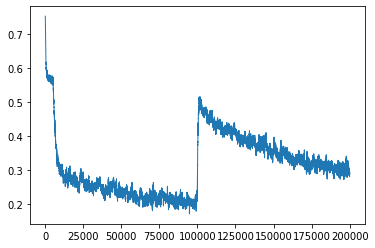

In [103]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [104]:
loss = None
cleanup()
model.eval();

In [105]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

  0%|          | 0/218 [00:00<?, ?it/s]

0.8291391308987522
recall@ ideal reject rate: 0.5968992248062015 th: 0.39926911103130397


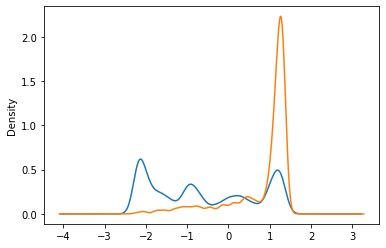

In [106]:
pd.Series(np.log10(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [107]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.7123162
0.7550200803212851


In [108]:
model.save_pretrained('../models/bak-ru-combined');

In [161]:
tokenizer.save_pretrained('../models/bak-ru-combined');

# Combined score from this model and LaBSE

In [109]:
from transformers import BertForPreTraining, BertTokenizer, BertTokenizerFast, BertConfig, AutoModel, AutoTokenizer
# from transformers import AlbertTokenizerFast, AlbertConfig, AlbertForPreTraining

In [110]:
labse_ba_path = '../models/LaBSE-distilled-bak'
labse_ru_path = 'cointegrated/LaBSE-en-ru'

In [112]:
labse_ba_tokenizer = AutoTokenizer.from_pretrained(labse_ba_path)
labse_ba_model = AutoModel.from_pretrained(labse_ba_path).cuda()

Some weights of the model checkpoint at ../models/LaBSE-distilled-bak were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
labse_ru_tokenizer = AutoTokenizer.from_pretrained(labse_ru_path)
labse_ru_model = AutoModel.from_pretrained(labse_ru_path).cuda()

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [113]:
def embed(text, model, tokenizer, max_length=512):
    b = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.inference_mode():
        return torch.nn.functional.normalize(model(**b.to(model.device)).pooler_output).cpu().numpy()

In [115]:
embs_val_ru = np.concatenate([embed(t, labse_ru_model, labse_ru_tokenizer) for t in tqdm(data_val.ru)])
embs_val_ba = np.concatenate([embed(t, labse_ba_model, labse_ba_tokenizer) for t in tqdm(data_val.ba)])

  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

In [118]:
cos_val = (embs_val_ru * embs_val_ba).sum(1)

0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

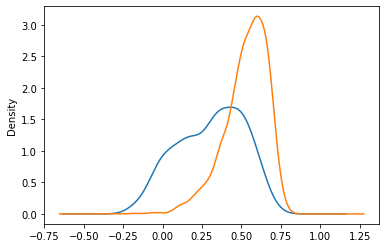

In [143]:
pd.Series(cos_val).groupby(data_val.is_correct.values).plot(kind='kde')

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression().fit(cos_val[:, np.newaxis], data_val.is_correct)
print(lr.coef_, lr.intercept_)
cos_logit = cos_val

[[6.19982792]] [-1.45385366]


In [145]:
print(cross_val_score(LogisticRegression(), cos_val[:, np.newaxis], data_val.is_correct, scoring='roc_auc').mean())
print(cross_val_score(LogisticRegression(), logits[:, np.newaxis], data_val.is_correct, scoring='roc_auc').mean())

print(cross_val_score(LogisticRegression(), np.stack([cos_val, logits]).T, data_val.is_correct, scoring='roc_auc').mean())
print(cross_val_score(LogisticRegression(), np.stack([cos_val, np.log(logits/(1-logits))]).T, data_val.is_correct, scoring='roc_auc').mean())

0.8139864811044537
0.8253044112388588
0.842896041987099
0.8451706558039312


In [146]:
lr = LogisticRegression().fit(np.stack([cos_val, np.log(logits/(1-logits))]).T, data_val.is_correct)
print(lr.coef_, lr.intercept_)

[[3.32790495 0.36929735]] [-0.42277911]


In [160]:
lr.coef_[0, 0] / lr.coef_[0, 1]

9.011450864437155

# Evaluate on the test part!

In [147]:
data_test= data[data.data_split=='test']
print(data_test.shape)

(35648, 5)


In [149]:
embs_test_ru = np.concatenate([embed(t, labse_ru_model, labse_ru_tokenizer) for t in tqdm(data_test.ru)])
embs_test_ba = np.concatenate([embed(t, labse_ba_model, labse_ba_tokenizer) for t in tqdm(data_test.ba)])

  0%|          | 0/35648 [00:00<?, ?it/s]

  0%|          | 0/35648 [00:00<?, ?it/s]

In [150]:
cos_test = (embs_test_ru * embs_test_ba).sum(1)

In [151]:
model.eval();

test_proba = []
for i in trange(0, data_test.shape[0], eval_bs):
    batch = data_test.iloc[i:i+eval_bs]
    with torch.inference_mode():
        test_proba.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
test_proba = pd.Series(test_proba, index=data_test.index)

  0%|          | 0/4456 [00:00<?, ?it/s]

In [152]:
test_logits = np.log(test_proba/(1-test_proba))

In [154]:
def print_eval(pred, fact):
    print('AUC:', roc_auc_score(fact, pred))
    threshold = np.quantile(pred, 1-fact.mean())
    print('recall@ ideal reject rate:', (pred < threshold)[fact.values==0].mean(), 'th:', threshold)

print('LaBSE')
print_eval(cos_test, data_test.is_correct)

print('Cross-encoder')
print_eval(test_proba, data_test.is_correct)

print('Combo')
print_eval(lr.predict_proba(np.stack([cos_test, test_logits]).T)[:, 1], data_test.is_correct)

LaBSE
AUC: 0.8054295153146105
recall@ ideal reject rate: 0.5724102825146348 th: 0.37793938291745677
Cross-encoder
AUC: 0.8219140760554539
recall@ ideal reject rate: 0.597480274879104 th: 0.4621652300357551
Combo
AUC: 0.8341760999555716
recall@ ideal reject rate: 0.6184779842199033 th: 0.699792500919


In [155]:
combo_proba = pd.Series(lr.predict_proba(np.stack([cos_test, test_logits]).T)[:, 1], index=data_test.index)

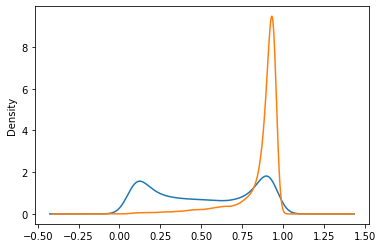

In [159]:
combo_proba.groupby(data_test.is_correct).plot(kind='kde');

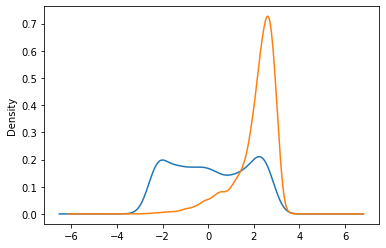

In [158]:
np.log(combo_proba/(1-combo_proba)).groupby(data_test.is_correct).plot(kind='kde');

In [163]:

data_test['score_labse'] = cos_test
data_test['score_clf'] = test_proba
data_test['score_combo'] = combo_proba

C:\Users\david\AppData\Local\Temp/ipykernel_11792/753289719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['score_labse'] = cos_test
C:\Users\david\AppData\Local\Temp/ipykernel_11792/753289719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['score_clf'] = test_proba
C:\Users\david\AppData\Local\Temp/ipykernel_11792/753289719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [166]:
data_test.index.name = 'index'

In [167]:
data_test.to_csv('../data/test_scored.tsv', sep='\t')

In [169]:
data_test.sample(5)

,date,ba,ru,is_correct,data_split,score_labse,score_clf,score_combo
index,,,,,,,,
28586,21/10/2021 11:40:16,"Үҙегеҙ күрҙегеҙ, был алышыбыҙ буталсығыраҡ кил...",Вы сами видели: сражение получилось беспорядоч...,1,test,0.387819,0.943069,0.870408
35772,09/11/2021 09:43:06,Уның тураһында ни уйларҙар һәм ул һуңынан үҙе ...,Что о нем подумают и что он потом будет думать...,1,test,0.590361,0.950431,0.932932
41491,08/05/2022 11:39:28,"Мин, бөйөк государь, анператор Петр Федорович,...","Я, великий государь, анператор Петр Федорович,...",1,test,0.576549,0.937227,0.923740
151368,22/06/2022 10:52:55,«Уйлап ҡарармын».,"— Ладно, подумаю, ежели не поздно.",0,test,0.233996,0.111575,0.398849
143696,16/10/2021 14:37:55,Тәүге төндә таң алдынан ғына серемгә китте Алд...,Этой ночью Алдар заснул лишь перед самым рассв...,0,test,0.417571,0.052418,0.474490
